## Imports

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import transforms
import numpy as np

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, r'E:\GitHub\smart-parking-system')

from system.detection.model import deeplab_v3
import system.backend.utils.utils as utils

## Utils

In [2]:
def show_images(images, cols=1, prefix='Image ', titles=None):
    # https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
    assert((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None:
        titles = [f'{prefix} ({i})' for i in range(1, n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(int(cols), int(np.ceil(n_images/float(cols))), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    
def plot(img, pred, threshold=0.1):
    plt.figure(figsize=(20,20));
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(torch.squeeze(pred).cpu().numpy()>threshold)
    plt.title('Segmentation Output')
    plt.axis('off')

def pred(image, model):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)
    
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')

    with torch.no_grad():
        output = model(input_batch)
        return output

## Load model into memory

In [3]:
model = deeplab_v3('resnet101', 'imagenet', ['license-plate'], 'sigmoid')
checkpoint = torch.load(r'E:\GitHub\smart-parking-system\system\detection\training\experiment_v0.02\model_checkpoints\v0.02_e59_l0.125.pt', map_location='cpu')
model.load_state_dict(checkpoint)
_ = model.eval()

if torch.cuda.is_available():
    model.to('cuda')

## Make predictions

In [25]:
validation_images_path = r"E:\GitHub\smart-parking-system\dataset\segmentation\validation\images"
segmented_plates_results = r"E:\GitHub\smart-parking-system\dataset\license-plates\segmented"

In [26]:
images = os.listdir(r'E:\GitHub\smart-parking-system\dataset\segmentation\validation\images')

In [27]:
for image_name in images:
    image = Image.open(os.path.join(validation_images_path, image_name)).convert('RGB')
    outputs = pred(image=image, model=model)
    mask = torch.squeeze(outputs).cpu().numpy()>0.7
    mask = np.array(Image.fromarray(mask).convert("RGB"))
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    license_plates = utils.extract_segmentation_results(image, mask, sharpen_amount=50)
    for idx in range(len(license_plates)):
        Image.fromarray(license_plates[idx]).save(os.path.join(segmented_plates_results, image_name.split(".")[0] + "_" + str(idx) + ".jpg"))

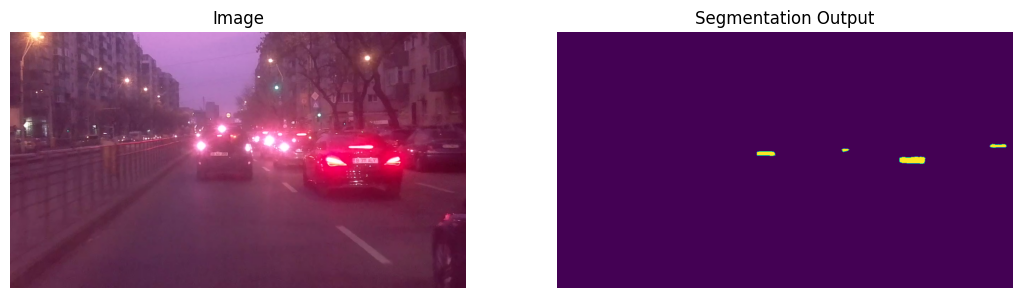

In [10]:
image = Image.open(r"E:\GitHub\smart-parking-system\dataset\segmentation\test\images\lpdr_sample_338.jpg").convert('RGB')
outputs = pred(image=image, model=model)
plot(image, outputs, threshold=0.7)

mask = torch.squeeze(outputs).cpu().numpy()>0.7
mask = np.array(Image.fromarray(mask).convert("RGB"))
mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)

## Extract license plates

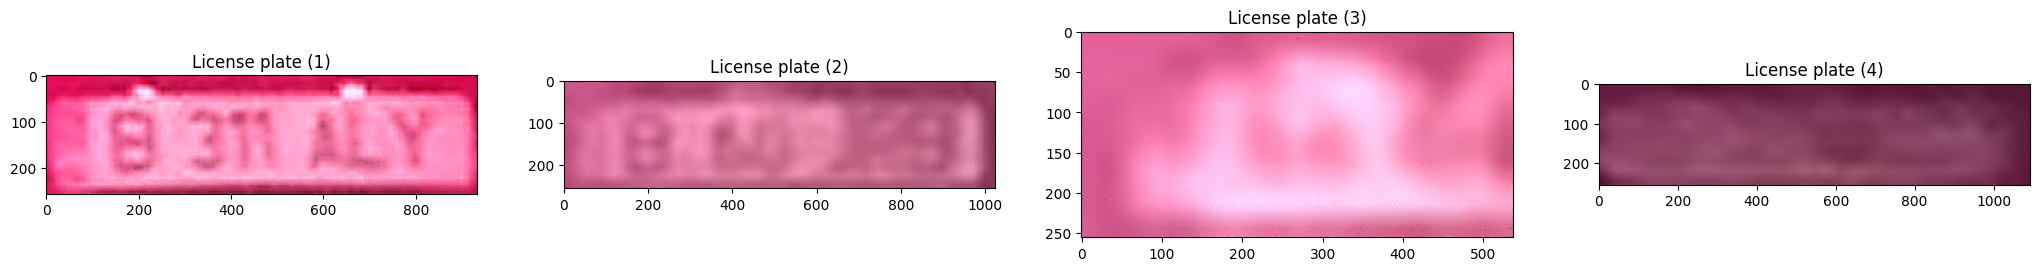

In [11]:
license_plates = utils.extract_segmentation_results(image, mask, sharpen_amount=50)
show_images(license_plates, prefix='License plate')

In [13]:
type(license_plates)

list

In [14]:
type(license_plates[0])

numpy.ndarray

In [15]:
license_plates[0].shape

(256, 934, 3)

In [16]:
Image.fromarray(license_plates[0]).show()

In [18]:
len(license_plates)

4